In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [2]:
FIG_REG_WIDTH = 7
FIG_REG_ASPECT_RATIO = 1.75

def set_fig_settings(fig_size=(32,10), font_size=16, font_scale=1.6):       
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams["legend.framealpha"] = 0

    font = {'weight' : 'normal', 'size'   : font_size}

    plt.rc('font', **font)

In [3]:
DATASET_PATH = 'data/uci_ml_hackathon_fire_dataset_2012-05-09_2013-01-01_10k_train.hdf5'

with h5py.File(DATASET_PATH, 'r') as f:
    train_data = {}
    for k in list(f):
        train_data[k] = f[k][:]

In [4]:
print(train_data.keys())

dict_keys(['datetime', 'land_cover', 'latitude', 'longitude', 'meteorology', 'observed', 'target'])


In [5]:
LAND_COVER_LAYER_NAME_TO_IND = {'ASP': 0, 'CBD': 1, 'CBH': 2, 'CC': 3, 'CH': 4, 'DEM': 5, 'EVT': 6, 'SLP': 16}
VEGETATION_NAME_TO_IND = {'Nodata': 0, 'Sparse': 1, 'Tree': 2, 'Shrub': 3, 'Herb': 4, 'Water': 5, 'Barren': 6, 'Developed': 7, 'Snow-Ice': 8, 'Agriculture': 9}

TOPO_NAMES = ['ASP', 'SLP', 'DEM']
VEG_NAME = 'EVT'
FUEL_NAMES = ['CBD', 'CBH', 'CC', 'CH']

In [6]:
for key in train_data:
    print(key, len(train_data[key]),' ', type(train_data[key]),' ', train_data[key].shape)


datetime 10000   <class 'numpy.ndarray'>   (10000,)
land_cover 10000   <class 'numpy.ndarray'>   (10000, 17, 30, 30)
latitude 10000   <class 'numpy.ndarray'>   (10000,)
longitude 10000   <class 'numpy.ndarray'>   (10000,)
meteorology 10000   <class 'numpy.ndarray'>   (10000, 2, 5, 30, 30)
observed 10000   <class 'numpy.ndarray'>   (10000, 5, 30, 30)
target 10000   <class 'numpy.ndarray'>   (10000, 2, 30, 30)


### Vegetation Analysis

In [100]:
nPoints=10000
vegetation_summary = np.zeros((nPoints, len(VEGETATION_NAME_TO_IND)))

for datapointIdx in range(nPoints):
    for i, (name, ind) in enumerate(VEGETATION_NAME_TO_IND.items()):
#                 sum_point[x][y] = sum_point[x][y] + train_data['land_cover'][datapointIdx][i][x][y]
        j = LAND_COVER_LAYER_NAME_TO_IND[VEG_NAME]+ind
        
        vegetation_summary[datapointIdx][i] = np.mean(train_data['land_cover'][datapointIdx][j])

vegSum = pd.DataFrame(vegetation_summary, columns=VEGETATION_NAME_TO_IND.keys())

In [102]:
vegSum.describe()

,Nodata,Sparse,Tree,Shrub,Herb,Water,Barren,Developed,Snow-Ice,Agriculture
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.014555,0.012443,0.560801,0.132533,0.222665,0.011672,0.007635,0.013076,0.0,0.024619
std,0.065910,0.025757,0.273889,0.116589,0.218308,0.034340,0.029092,0.043793,0.0,0.113220
min,0.000000,0.000000,0.000000,0.000000,0.000633,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.001840,0.353284,0.055253,0.061941,0.000462,0.000036,0.000071,0.0,0.000000
50%,0.000000,0.006066,0.668864,0.098446,0.144558,0.002603,0.000811,0.004700,0.0,0.000000
75%,0.000000,0.014572,0.773972,0.177159,0.311778,0.007275,0.003172,0.011351,0.0,0.000007
max,0.545500,0.630258,0.973881,0.858297,0.980366,0.496619,0.484892,0.826752,0.0,0.856910


In [103]:
vegSum.to_csv('vegetationSummary.csv', index=False)

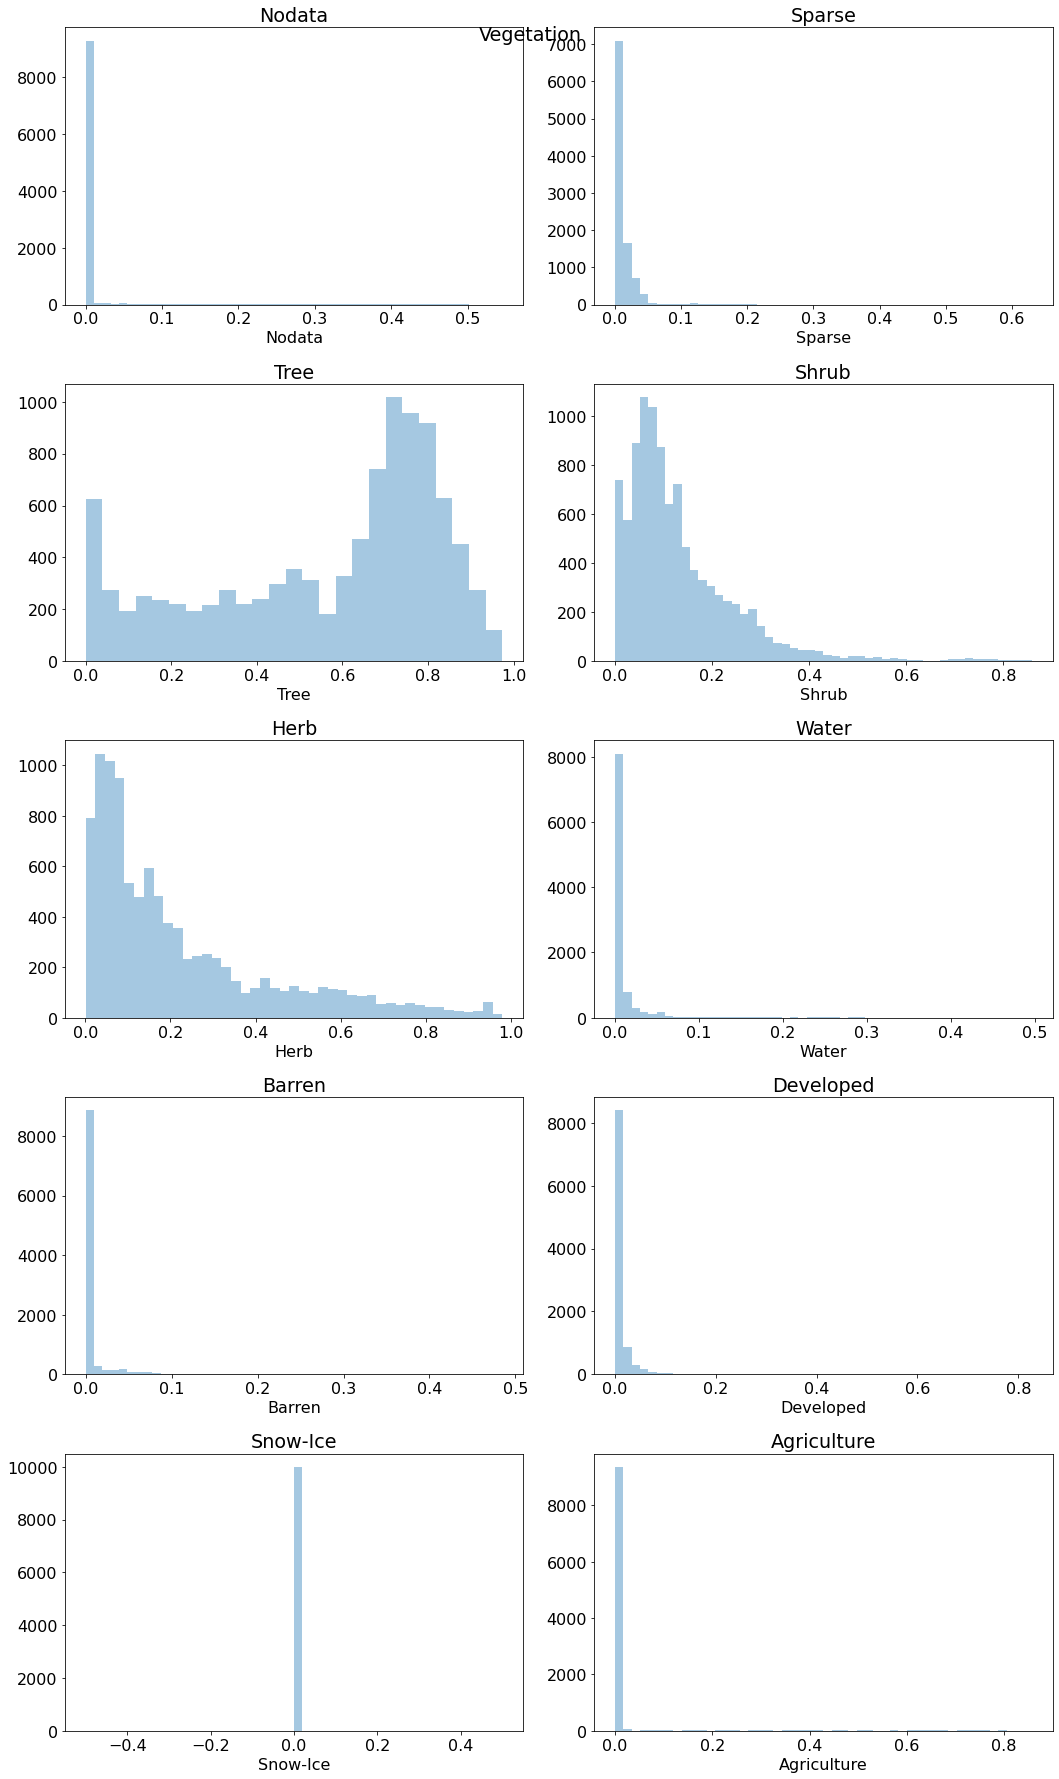

In [138]:
set_fig_settings(fig_size=(15,25))
fig = plt.figure()

fig.suptitle('Vegetation\n')
for i, (name, ind) in enumerate(VEGETATION_NAME_TO_IND.items()):
    plt.subplot(5,len(VEGETATION_NAME_TO_IND)//5,i+1)
#     plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[VEG_NAME] + ind])
    sb.distplot(vegSum[name], kde = False)
    plt.title(name)

plt.tight_layout()
plt.show()

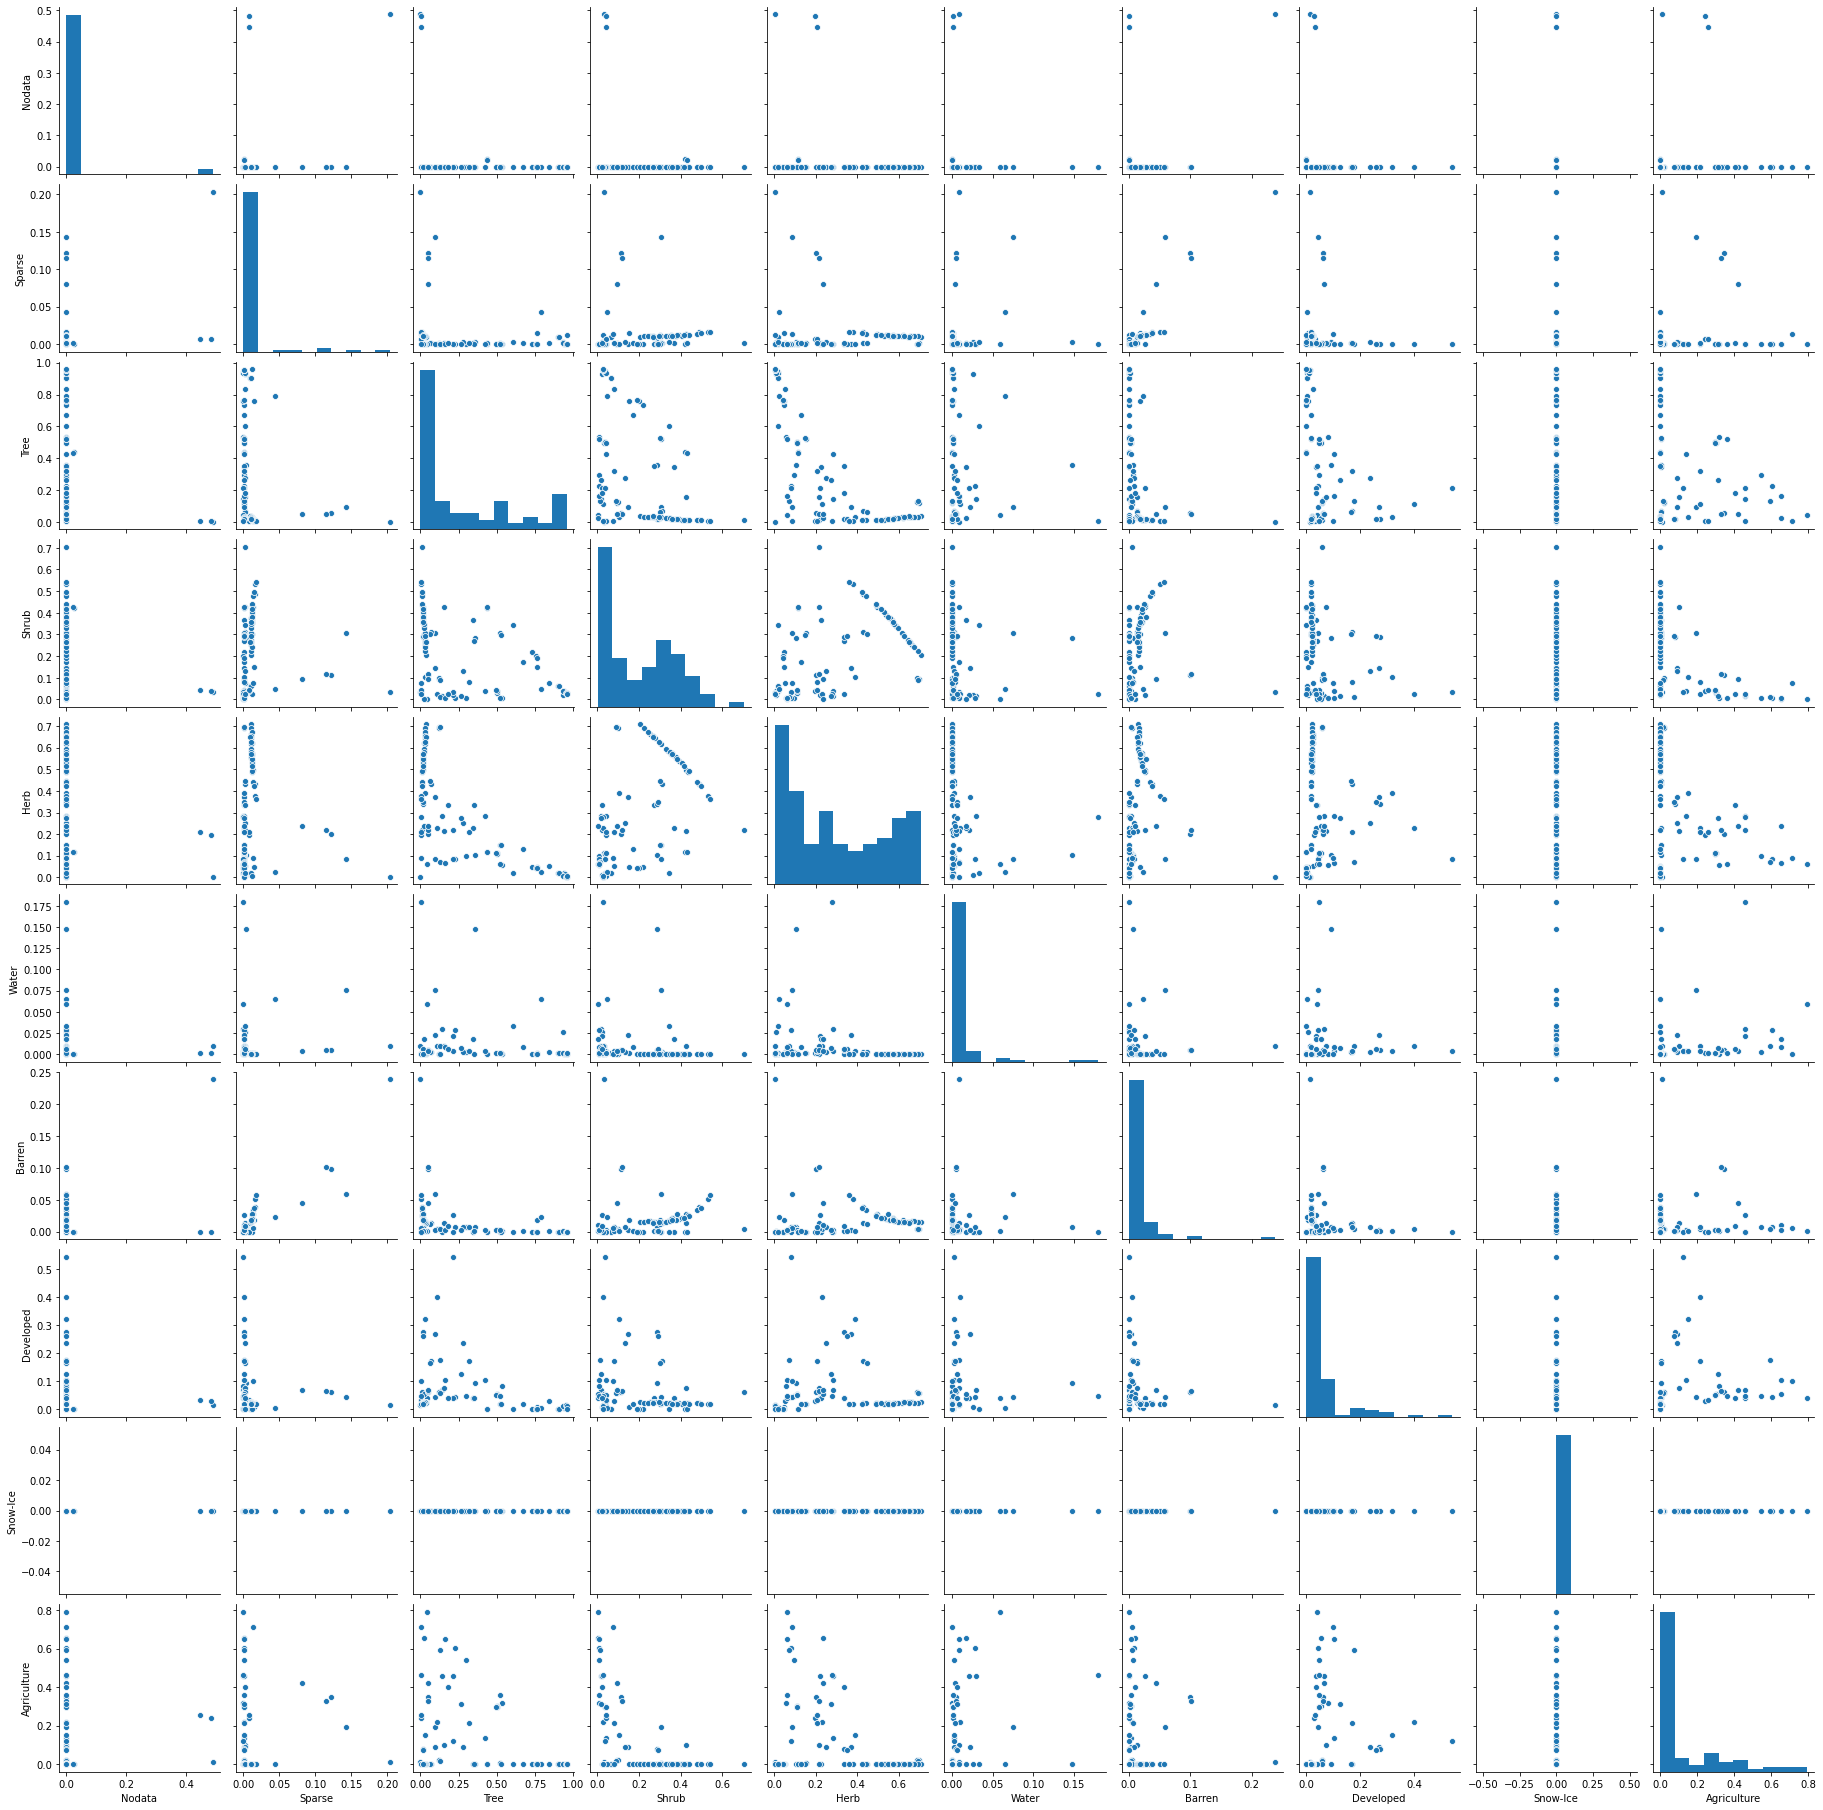

In [119]:
sb.pairplot(vegSum[:100])

Pair plot for only the first 100 elements

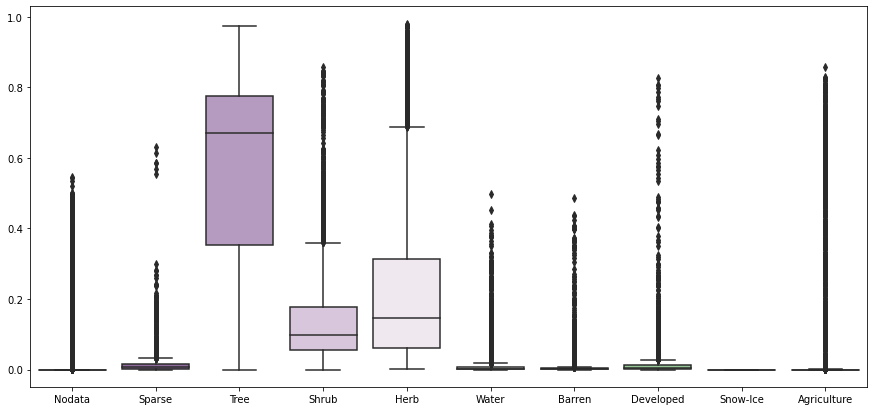

In [120]:
f,ax = plt.subplots(figsize =(15,7))
sb.boxplot(data=vegSum,palette="PRGn",ax=ax)
plt.show()

Snow-Ice has no datapoints.
Agriculture also has very less information

### Fuel Analysis

In [139]:
FUEL_NAMES

['CBD', 'CBH', 'CC', 'CH']

In [203]:
nPoints=10000
fuel_summary = np.zeros((nPoints, len(FUEL_NAMES)))

for datapointIdx in range(nPoints):
    for i, name in enumerate(FUEL_NAMES):
        j = LAND_COVER_LAYER_NAME_TO_IND[name]
        
        # replace nan
        nan_mask = np.isnan(train_data['land_cover'][datapointIdx][j])
        train_data['land_cover'][datapointIdx][j][nan_mask]=0
        
#         if i==0:
#             print(np.unique(np.isnan(train_data['land_cover'][datapointIdx][j])))
        fuel_summary[datapointIdx][i] = np.mean(train_data['land_cover'][datapointIdx][j])

fuelSum = pd.DataFrame(fuel_summary, columns=FUEL_NAMES)

In [204]:
fuelSum.describe()

,CBD,CBH,CC,CH
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.336532,9.068416,25.289850,147.013944
std,2.656795,7.329714,15.922344,94.415286
min,0.000000,0.000000,0.000000,0.000000
25%,2.154625,5.201828,9.067640,44.234798
50%,4.746400,7.482986,29.458915,183.856895
75%,6.077605,10.128187,36.494843,222.012806
max,17.954382,54.968723,66.734261,326.177612


#### NULL VALUES EXIST where no FOREST
LANDFIRE's (LF) **Forest Canopy Cover (CC) describes the percent cover of the tree canopy** in a stand. Specifically, canopy cover describes the vertical projection of the tree canopy onto an imaginary horizontal surface representing the ground's surface. 

CC is used in the calculation of Canopy Bulk Density and Canopy Base Height. CC supplies information to fire behavior models to determine the probability of crown fire initiation, provide input in the spotting model, calculate wind reductions, and calculate fuel moisture conditioning. 

LANDFIRE's (LF) **Forest Canopy Height (CH) describes the average height of the top of the vegetated canopy. CH measurement units are meters * 10** and extracted from Existing Vegetation Height (EVH). CH is assigned the midpoint of the EVH forested classes at non-disturbed locations. These products are provided for forested areas only.

CH is used in the calculation of Canopy Bulk Density and Canopy Base Height. CH supplies information to fire behavior models to provide input in the spotting model and calculate wind reductions. 

LANDFIRE's (LF) **Forest Canopy Bulk Density (CBD) describes the density of available canopy fuel in a stand**. It is defined as the mass of available canopy fuel per canopy volume unit. **CBD unit measurements are kg m-3 * 100**. These products are provided for forested areas only.

CBD supplies information for fire behavior models, such as FARSITE, to determine the initiation and spread characteristics of crown fires across landscapes. 

LANDFIRE's (LF) **Forest Canopy Base Height (CBH) describes the average height from the ground to a forest stand's canopy bottom**. Specifically, it is the lowest height in a stand at which there is enough forest canopy fuel to propagate fire vertically into the canopy. **CBH unit measurements are meters * 10**. These products are provided for forested areas only.

CBH provides information for fire behavior models to determine areas in which a surface fire is likely to transition to a crown fire.

Good Link: https://www.nwcg.gov/publications/pms437/fuels/canopy-fuel-characteristics


In [205]:
fuelSum.to_csv('fuelSummary.csv', index=False)

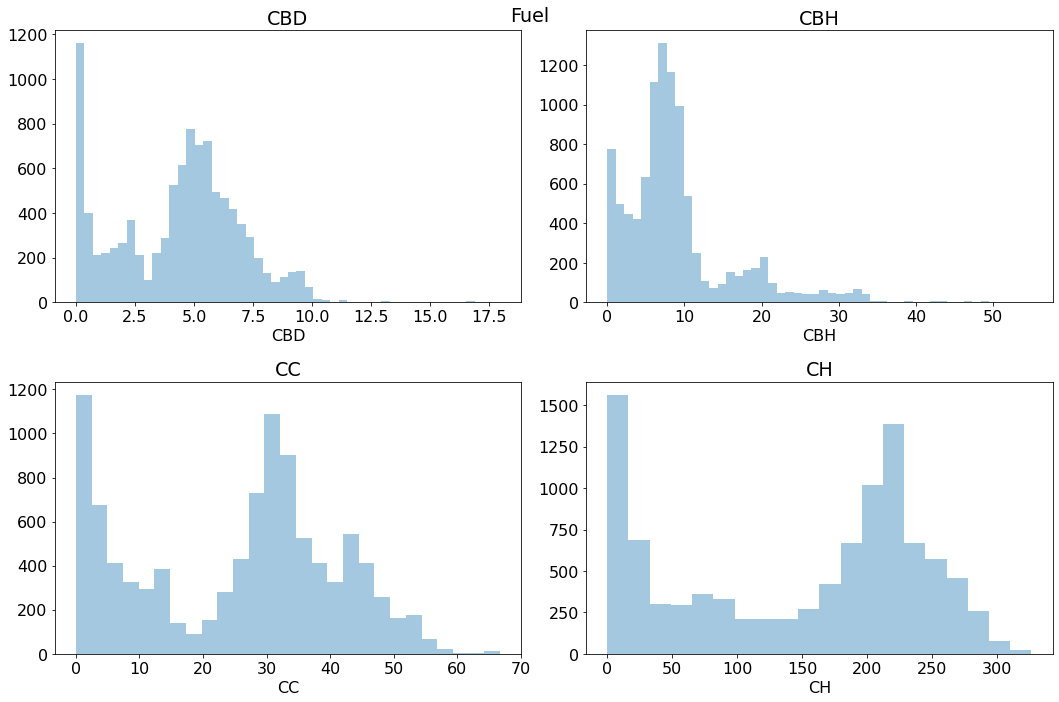

In [210]:
set_fig_settings(fig_size=(15,10))
fig = plt.figure()

fig.suptitle('Fuel\n')
for i, name in enumerate(FUEL_NAMES):
    plt.subplot(2,len(FUEL_NAMES)//2,i+1)
#     plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[name]])
    sb.distplot(fuelSum[name], kde=False)
    plt.title(name)
#     plt.axis('off')

plt.tight_layout()
plt.show()


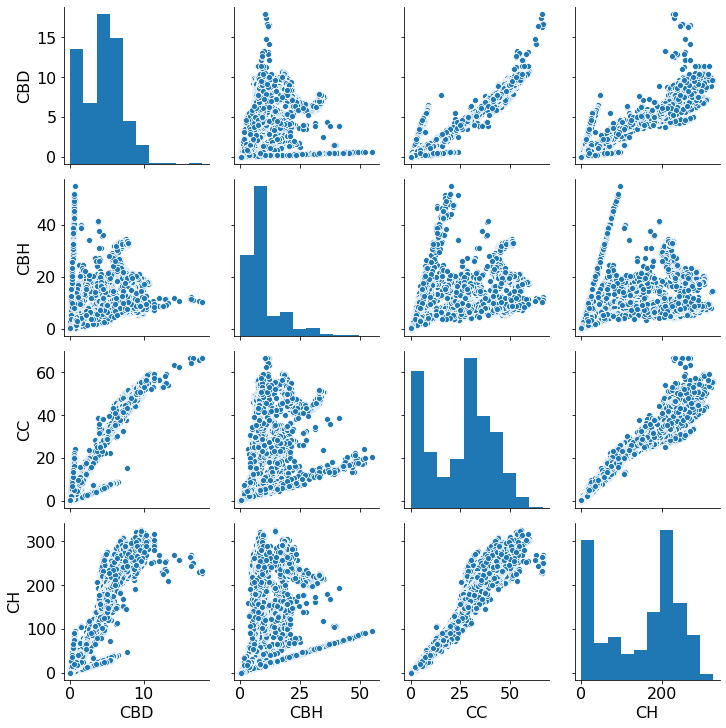

In [215]:
sb.pairplot(fuelSum)

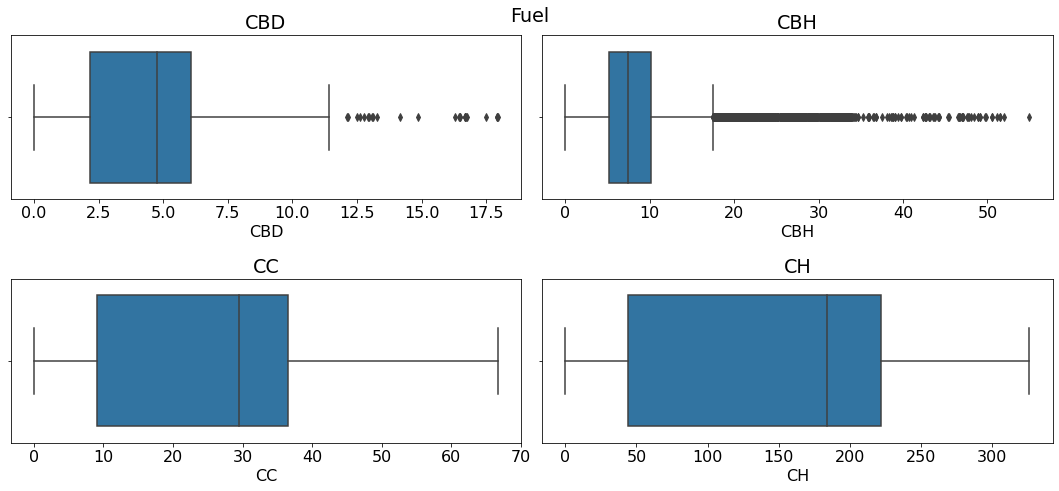

In [224]:
set_fig_settings(fig_size=(15,7))
fig = plt.figure()

fig.suptitle('Fuel\n')
for i, name in enumerate(FUEL_NAMES):
    plt.subplot(2,len(FUEL_NAMES)//2,i+1)
#     plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[name]])
    sb.boxplot(fuelSum[name])
    plt.title(name)
#     plt.axis('off')

plt.tight_layout()
plt.show()


### Side Work (Not Imp)

In [90]:
thresh=0.1
nPoints=1000
count=0
for datapointIdx in range(nPoints):
    if (np.max(train_data['land_cover'][datapointIdx][6])>0.5):
        count = count+1
#         print(datapointIdx)
#         print(np.unique(train_data['land_cover'][datapointIdx][6]))

print(count, "Rows with atleast a sigle no data pizel in ", nPoints,"checked ")

33 Rows with atleast a sigle no data pizel in  1000 checked 


In [200]:
try1 = train_data['land_cover'][0][1]
nan_mask = np.isnan(try1)
# if len(np.unique(nan_mask))>1:
try1[nan_mask] = 0
np.argwhere(np.isnan(try1))

array([], shape=(0, 2), dtype=int64)

### Meterology Analysis

In [7]:
METEOROLOGY_NAME_TO_IND = {'Temp': 0, 'Rel. Humid.': 1, 'U Wind Comp.': 2, 'V Wind Comp.': 3, 'Precip. Rate': 4}

In [8]:
print('Shape:', train_data['meteorology'].shape, '= (# of Instances, Timesteps, # of Variables, Width, Height)')

Shape: (10000, 2, 5, 30, 30) = (# of Instances, Timesteps, # of Variables, Width, Height)


In [14]:
nPoints=10000
meterology_summary = np.zeros((nPoints*2, len(METEOROLOGY_NAME_TO_IND)))

for datapointIdx in range(nPoints):
    for i, (name, ind) in enumerate(METEOROLOGY_NAME_TO_IND.items()):
        meterology_summary[2*datapointIdx][i] = np.mean(train_data['meteorology'][datapointIdx][0][ind])
        meterology_summary[2*datapointIdx+1][i] = np.mean(train_data['meteorology'][datapointIdx][1][ind])

metSum = pd.DataFrame(meterology_summary, columns=METEOROLOGY_NAME_TO_IND.keys())

In [16]:
metSum.to_csv('meteorologySummary.csv', index=False)

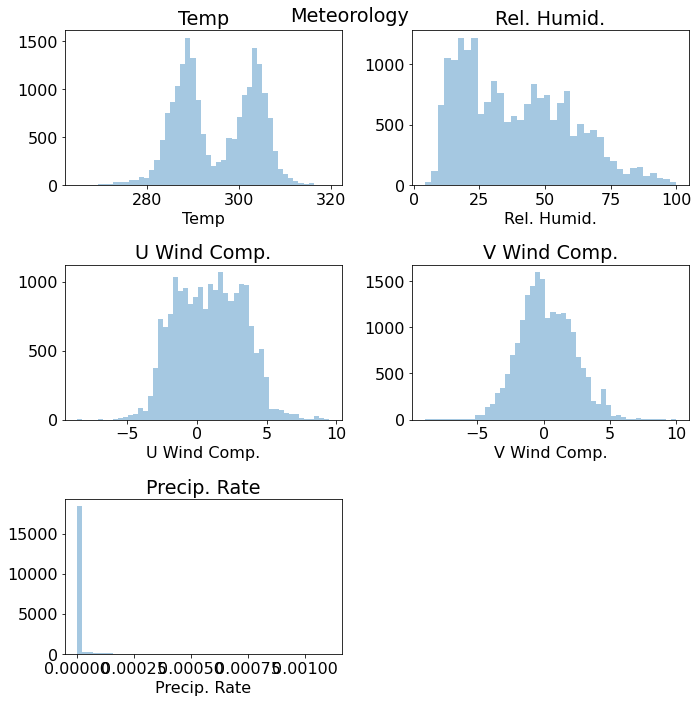

In [26]:
set_fig_settings(fig_size=(10,10))
fig = plt.figure()

fig.suptitle('Meteorology\n')
for i, (name, ind) in enumerate(METEOROLOGY_NAME_TO_IND.items()):
    plt.subplot(len(METEOROLOGY_NAME_TO_IND)//2+1,2,i+1)
#     plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[name]])
    sb.distplot(metSum[name], kde=False)
    plt.title(name)
#     plt.axis('off')

plt.tight_layout()
plt.show()


no information in precipitate rate

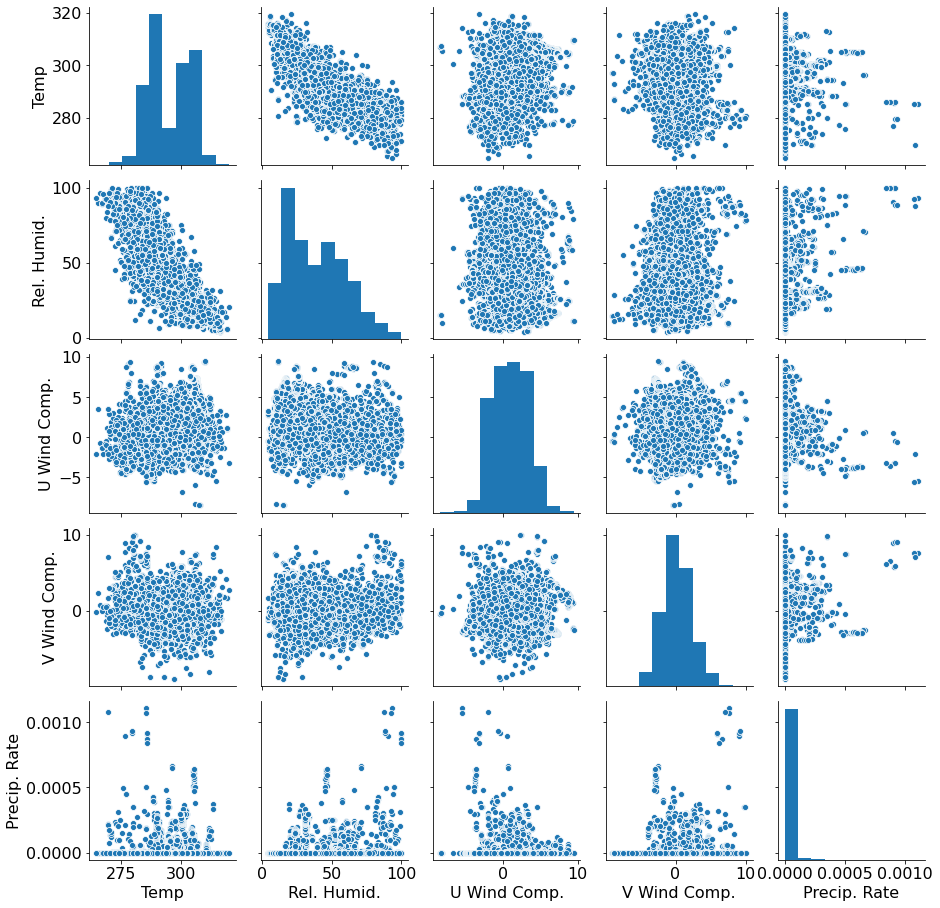

In [28]:
sb.pairplot(metSum)

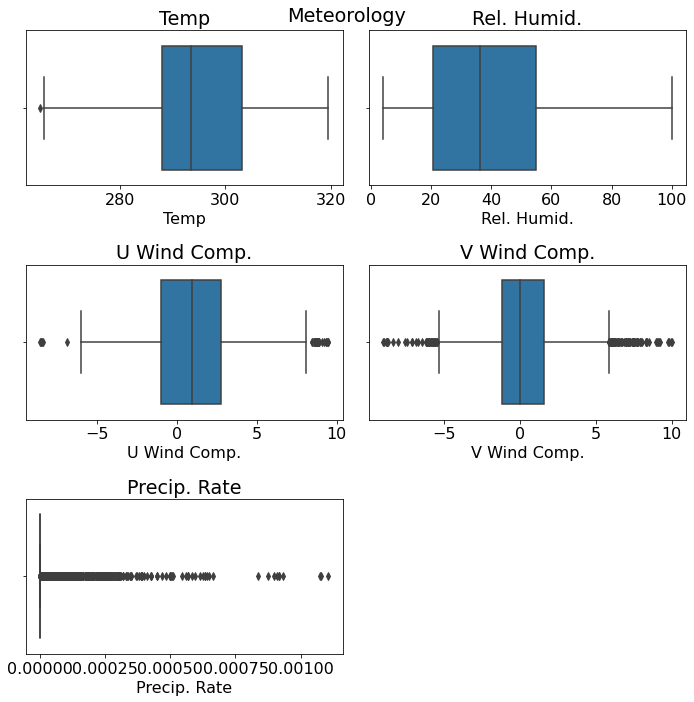

In [29]:
set_fig_settings(fig_size=(10,10))
fig = plt.figure()

fig.suptitle('Meteorology\n')
for i, (name, ind) in enumerate(METEOROLOGY_NAME_TO_IND.items()):
    plt.subplot(len(METEOROLOGY_NAME_TO_IND)//2+1,2,i+1)
#     plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[name]])
    sb.boxplot(metSum[name])
    plt.title(name)
#     plt.axis('off')

plt.tight_layout()
plt.show()